Before SMOTE: {'H': 3439, 'A': 2214, 'D': 1851}
After SMOTE: {'D': 3439, 'H': 3439, 'A': 3439}


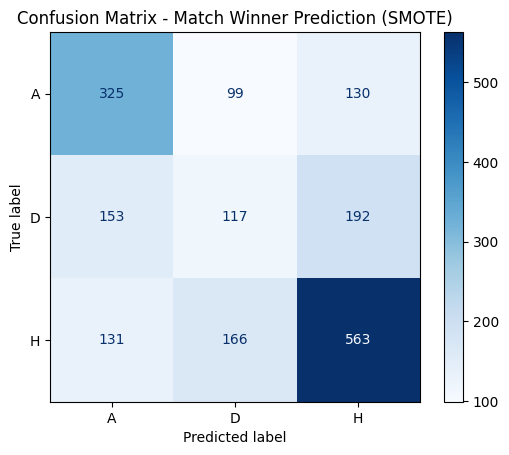

Model Accuracy: 0.54

Classification Report:
              precision    recall  f1-score   support

           A       0.53      0.59      0.56       554
           D       0.31      0.25      0.28       462
           H       0.64      0.65      0.65       860

    accuracy                           0.54      1876
   macro avg       0.49      0.50      0.49      1876
weighted avg       0.52      0.54      0.53      1876


Feature Importance Ranking:
1. HomeTeam: 0.1038
2. HomeShotsOnTarget: 0.1031
3. AwayTeam: 0.1010
4. HomeShots: 0.0882
5. AwayShotsOnTarget: 0.0879
6. AwayShots: 0.0840
7. HomeFouls: 0.0835
8. AwayFouls: 0.0833
9. HomeCorners: 0.0756
10. AwayCorners: 0.0742
11. AwayYellowCards: 0.0505
12. HomeYellowCards: 0.0485
13. AwayRedCards: 0.0095
14. HomeRedCards: 0.0072


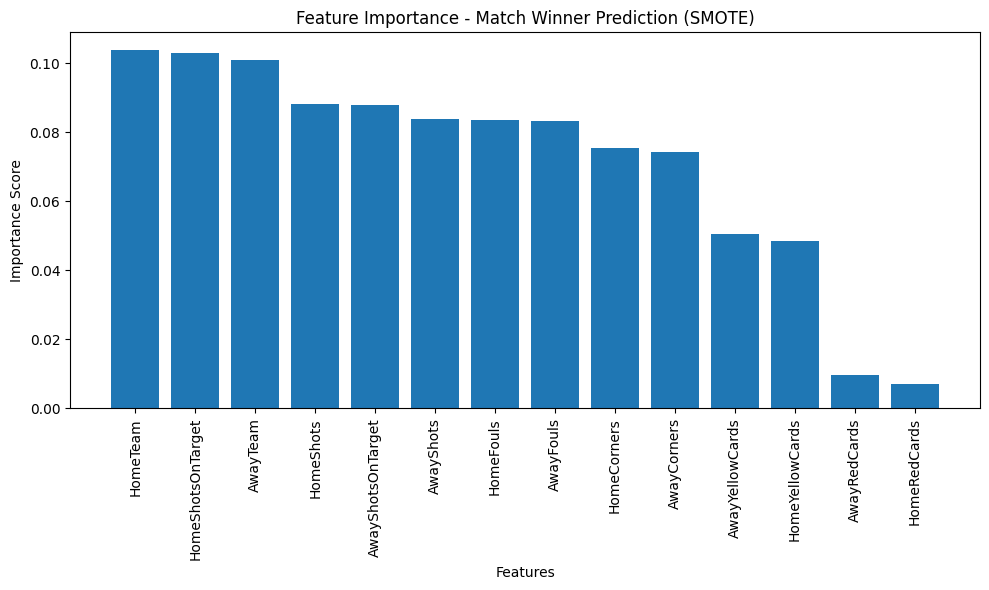

In [1]:
# ===============================
# Match Winner Prediction + SMOTE + Feature Importance
# ===============================

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report
)
from imblearn.over_sampling import SMOTE

# 1. Load dataset
file_path = "/content/every_match.csv"   # <-- update if needed
df = pd.read_csv(file_path)

# 2. Target column
y = df["FullTimeResult"]

# 3. Drop ONLY the real leakage columns
leakage_cols = [
    "FullTimeHomeGoals", "FullTimeAwayGoals",
    "HalfTimeHomeGoals", "HalfTimeAwayGoals", "HalfTimeResult"
]
X = df.drop(columns=["Season", "MatchDate", "FullTimeResult"] + leakage_cols)

# 4. Encode categorical features (teams)
for col in X.columns:
    if X[col].dtype == "object":
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 6. Apply SMOTE to training data
smote = SMOTE(random_state=42, sampling_strategy="auto")  # "auto" balances all classes
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_resampled.value_counts().to_dict())

# 7. Train model on balanced data
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# 8. Predictions
y_pred = clf.predict(X_test)

# 9. Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Match Winner Prediction (SMOTE)")
plt.show()

# 10. Accuracy & Report
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 11. Feature Importance
importances = clf.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

# Print ranking
print("\nFeature Importance Ranking:")
for i in range(len(features)):
    print(f"{i+1}. {features[indices[i]]}: {importances[indices[i]]:.4f}")

# Plot graph
plt.figure(figsize=(10,6))
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.title("Feature Importance - Match Winner Prediction (SMOTE)")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.tight_layout()
plt.show()
